# Crystal Graph Convolutional Neural Networks (CGCNN) - Data Loading Module

## Overview

This notebook implements the data loading and preprocessing pipeline for Crystal Graph Convolutional Neural Networks (CGCNN), a deep learning framework for predicting properties of crystalline materials.

### Key Concepts

1. **Crystal Structure Representation**: Crystals are represented as graphs where:
   - Nodes represent atoms
   - Edges represent bonds/interactions between neighboring atoms
   - Node features encode atomic properties
   - Edge features encode distance information

2. **Graph Construction**: For each crystal structure:
   - Extract atomic features from a pre-defined embedding
   - Identify neighbors within a cutoff radius
   - Encode distances using Gaussian basis functions

3. **Batch Processing**: Multiple crystal graphs are collated into batches for efficient training.

## 1. Import Required Libraries

We'll need:
- **PyTorch**: For tensor operations and data loading
- **Pymatgen**: For parsing crystal structures from CIF files
- **NumPy**: For numerical operations
- **Standard libraries**: For file I/O and data manipulation

In [1]:
from __future__ import print_function, division

import csv
import functools
import json
import os
import random
import warnings

import numpy as np
import torch
from pymatgen.core.structure import Structure
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

PyTorch version: 2.9.0+cu126
NumPy version: 2.3.4


## 2. Gaussian Distance Expansion

### Theory

**Gaussian Distance Filters** convert scalar distances into fixed-length feature vectors using Gaussian basis functions:

$$
\phi_k(d) = \exp\left(-\frac{(d - \mu_k)^2}{\sigma^2}\right)
$$

where:
- $d$ is the interatomic distance
- $\mu_k$ are the centers of Gaussian functions (uniformly spaced from $d_{min}$ to $d_{max}$)
- $\sigma$ is the width of the Gaussian (typically equal to step size)

### Benefits
- **Smooth representation**: Continuous encoding of distance information
- **Fixed dimensionality**: All edges have the same feature dimension
- **Differentiable**: Suitable for gradient-based optimization

In [2]:
class GaussianDistance(object):
    """
    Expands the distance by Gaussian basis.

    Unit: angstrom
    """
    def __init__(self, dmin, dmax, step, var=None):
        """
        Parameters
        ----------
        dmin: float
          Minimum interatomic distance
        dmax: float
          Maximum interatomic distance
        step: float
          Step size for the Gaussian filter
        """
        assert dmin < dmax
        assert dmax - dmin > step
        self.filter = np.arange(dmin, dmax+step, step)
        if var is None:
            var = step
        self.var = var

    def expand(self, distances):
        """
        Apply Gaussian distance filter to a numpy distance array

        Parameters
        ----------
        distance: np.array shape n-d array
          A distance matrix of any shape

        Returns
        -------
        expanded_distance: shape (n+1)-d array
          Expanded distance matrix with the last dimension of length
          len(self.filter)
        """
        return np.exp(-(distances[..., np.newaxis] - self.filter)**2 /
                      self.var**2)

### Visualize Gaussian Distance Expansion

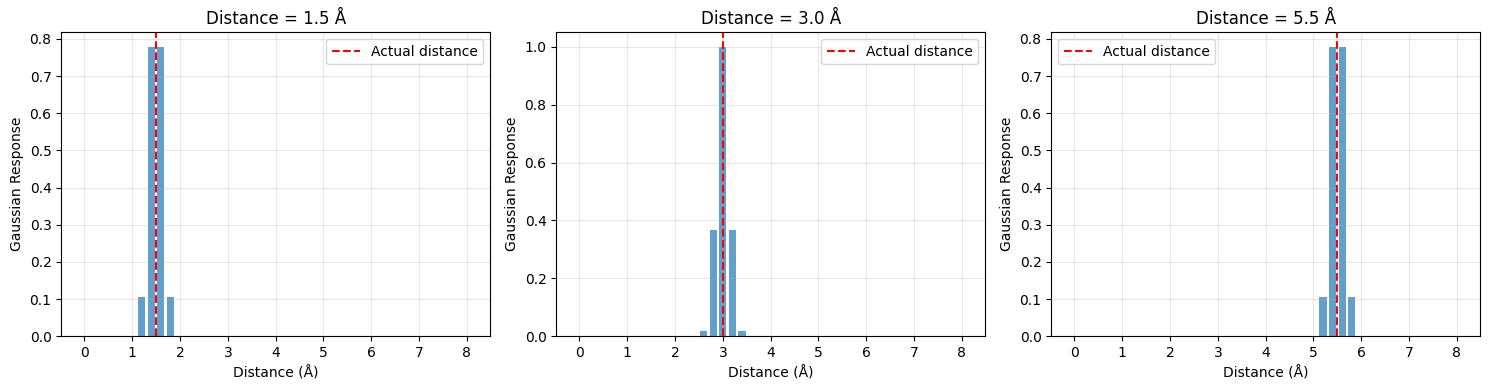

Number of Gaussian basis functions: 41
Expanded feature dimension per edge: 41


In [3]:
import matplotlib.pyplot as plt

gdf = GaussianDistance(dmin=0, dmax=8, step=0.2)

# Test with some example distances
test_distances = np.array([1.5, 3.0, 5.5])
expanded = gdf.expand(test_distances)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, d in enumerate(test_distances):
    axes[i].bar(gdf.filter, expanded[i], width=0.15, alpha=0.7)
    axes[i].set_xlabel('Distance (Å)')
    axes[i].set_ylabel('Gaussian Response')
    axes[i].set_title(f'Distance = {d:.1f} Å')
    axes[i].axvline(d, color='red', linestyle='--', label='Actual distance')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Number of Gaussian basis functions: {len(gdf.filter)}")
print(f"Expanded feature dimension per edge: {expanded.shape[1]}")

## 3. Atom Initialization

### Theory

**Atom Feature Vectors** provide initial representations for different elements. These can be:

1. **One-hot encoding**: Binary vectors indicating element type
2. **Physical properties**: Atomic radius, electronegativity, ionization energy, etc.
3. **Learned embeddings**: Pre-trained or trainable vectors

The `AtomCustomJSONInitializer` loads pre-defined feature vectors from a JSON file, where each element is mapped to its feature representation.

### Design Pattern
- **One initializer per dataset**: Ensures consistency across all structures
- **Flexible representation**: Easy to swap different embedding strategies

In [ ]:
class AtomInitializer(object):
    """
    Base class for initializing the vector representation for atoms.
    """
    def __init__(self, atom_types):
        self.atom_types = set(atom_types)
        self._embedding = {}

    def get_atom_fea(self, atom_type):
        assert atom_type in self.atom_types
        return self._embedding[atom_type]

    def load_state_dict(self, state_dict):
        self._embedding = state_dict
        self.atom_types = set(self._embedding.keys())
        self._decodedict = {idx: atom_type for atom_type, idx in
                            self._embedding.items()}

    def state_dict(self):
        return self._embedding

    def decode(self, idx):
        if not hasattr(self, '_decodedict'):
            self._decodedict = {idx: atom_type for atom_type, idx in
                                self._embedding.items()}
        return self._decodedict[idx]


class AtomCustomJSONInitializer(AtomInitializer):
    """
    Initialize atom feature vectors using a JSON file, which is a python
    dictionary mapping from element number to a list representing the
    feature vector of the element.

    Parameters
    ----------
    elem_embedding_file: str
        The path to the .json file
    """
    def __init__(self, elem_embedding_file):
        with open(elem_embedding_file) as f:
            elem_embedding = json.load(f)
        elem_embedding = {int(key): value for key, value
                          in elem_embedding.items()}
        atom_types = set(elem_embedding.keys())
        super(AtomCustomJSONInitializer, self).__init__(atom_types)
        for key, value in elem_embedding.items():
            self._embedding[key] = np.array(value, dtype=float)

### Example: Load and Inspect Atom Embeddings

In [ ]:
# Load atom embeddings
atom_init_file = '../atom_init.json'

if os.path.exists(atom_init_file):
    ari = AtomCustomJSONInitializer(atom_init_file)
    print(f"Number of element types: {len(ari.atom_types)}")
    print(f"\nElement atomic numbers: {sorted(list(ari.atom_types)[:20])}...")  # Show first 20
    
    # Show feature dimension
    sample_element = list(ari.atom_types)[0]
    sample_features = ari.get_atom_fea(sample_element)
    print(f"\nFeature vector dimension: {len(sample_features)}")
    print(f"Sample features for element {sample_element}: {sample_features[:10]}...")  # First 10 values
else:
    print(f"Atom initialization file not found at: {atom_init_file}")

## 4. Crystal Graph Dataset

### Theory: Graph Representation of Crystals

A crystal structure is converted into a graph $G = (V, E)$ where:

**Nodes (V)**:
- Each atom in the unit cell becomes a node
- Node features: $\mathbf{v}_i \in \mathbb{R}^d$ (atom embedding)

**Edges (E)**:
- Constructed between atoms within a cutoff radius $r_{cut}$
- Edge features: $\mathbf{e}_{ij} \in \mathbb{R}^{d_e}$ (Gaussian-expanded distance)
- Limited to $M$ nearest neighbors per atom

### Dataset Structure

The dataset expects the following directory structure:

```
root_dir/
├── id_prop.csv         # ID and target property values
├── atom_init.json      # Atom feature embeddings
├── id0.cif             # Crystal structure files
├── id1.cif
└── ...
```

### Key Parameters

- **max_num_nbr**: Maximum number of neighbors per atom (typically 12)
- **radius**: Cutoff distance for neighbor search (in Ångströms)
- **dmin, dmax, step**: Parameters for Gaussian distance expansion

In [ ]:
class CIFData(Dataset):
    """
    The CIFData dataset is a wrapper for a dataset where the crystal structures
    are stored in the form of CIF files.

    Parameters
    ----------
    root_dir: str
        The path to the root directory of the dataset
    max_num_nbr: int
        The maximum number of neighbors while constructing the crystal graph
    radius: float
        The cutoff radius for searching neighbors
    dmin: float
        The minimum distance for constructing GaussianDistance
    step: float
        The step size for constructing GaussianDistance
    random_seed: int
        Random seed for shuffling the dataset

    Returns
    -------
    atom_fea: torch.Tensor shape (n_i, atom_fea_len)
    nbr_fea: torch.Tensor shape (n_i, M, nbr_fea_len)
    nbr_fea_idx: torch.LongTensor shape (n_i, M)
    target: torch.Tensor shape (1, )
    cif_id: str or int
    """
    def __init__(self, root_dir, max_num_nbr=12, radius=8, dmin=0, step=0.2,
                 random_seed=123):
        self.root_dir = root_dir
        self.max_num_nbr, self.radius = max_num_nbr, radius
        assert os.path.exists(root_dir), 'root_dir does not exist!'
        id_prop_file = os.path.join(self.root_dir, 'id_prop.csv')
        assert os.path.exists(id_prop_file), 'id_prop.csv does not exist!'
        with open(id_prop_file) as f:
            reader = csv.reader(f)
            self.id_prop_data = [row for row in reader]
        random.seed(random_seed)
        random.shuffle(self.id_prop_data)
        atom_init_file = os.path.join(self.root_dir, 'atom_init.json')
        assert os.path.exists(atom_init_file), 'atom_init.json does not exist!'
        self.ari = AtomCustomJSONInitializer(atom_init_file)
        self.gdf = GaussianDistance(dmin=dmin, dmax=self.radius, step=step)

    def __len__(self):
        return len(self.id_prop_data)

    @functools.lru_cache(maxsize=None)  # Cache loaded structures
    def __getitem__(self, idx):
        cif_id, target = self.id_prop_data[idx]
        crystal = Structure.from_file(os.path.join(self.root_dir,
                                                   cif_id+'.cif'))
        atom_fea = np.vstack([self.ari.get_atom_fea(crystal[i].specie.number)
                              for i in range(len(crystal))])
        atom_fea = torch.Tensor(atom_fea)
        all_nbrs = crystal.get_all_neighbors(self.radius, include_index=True)
        all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]
        nbr_fea_idx, nbr_fea = [], []
        for nbr in all_nbrs:
            if len(nbr) < self.max_num_nbr:
                warnings.warn('{} not find enough neighbors to build graph. '
                              'If it happens frequently, consider increase '
                              'radius.'.format(cif_id))
                nbr_fea_idx.append(list(map(lambda x: x[2], nbr)) +
                                   [0] * (self.max_num_nbr - len(nbr)))
                nbr_fea.append(list(map(lambda x: x[1], nbr)) +
                               [self.radius + 1.] * (self.max_num_nbr -
                                                     len(nbr)))
            else:
                nbr_fea_idx.append(list(map(lambda x: x[2],
                                            nbr[:self.max_num_nbr])))
                nbr_fea.append(list(map(lambda x: x[1],
                                        nbr[:self.max_num_nbr])))
        nbr_fea_idx, nbr_fea = np.array(nbr_fea_idx), np.array(nbr_fea)
        nbr_fea = self.gdf.expand(nbr_fea)
        atom_fea = torch.Tensor(atom_fea)
        nbr_fea = torch.Tensor(nbr_fea)
        nbr_fea_idx = torch.LongTensor(nbr_fea_idx)
        target = torch.Tensor([float(target)])
        return (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id

## 5. Batch Collation Function

### Theory: Batching Variable-Sized Graphs

**Challenge**: Crystal structures have different numbers of atoms, making standard batching impossible.

**Solution**: Create a single large graph by:
1. Concatenating all atom features: $[\mathbf{v}_1^{(1)}, ..., \mathbf{v}_{n_1}^{(1)}, \mathbf{v}_1^{(2)}, ..., \mathbf{v}_{n_B}^{(B)}]$
2. Adjusting neighbor indices to account for offset
3. Maintaining mapping from crystal ID to atom indices

This creates a **batch graph** where subgraphs remain disconnected.

### Mathematical Representation

For a batch of $B$ crystals with $n_1, n_2, ..., n_B$ atoms:
- Total atoms: $N = \sum_{i=1}^B n_i$
- Batch atom features: $\mathbf{V}_{batch} \in \mathbb{R}^{N \times d}$
- Crystal-to-atom mapping preserves graph structure for pooling

In [ ]:
def collate_pool(dataset_list):
    """
    Collate a list of data and return a batch for predicting crystal
    properties.

    Parameters
    ----------
    dataset_list: list of tuples for each data point.
      (atom_fea, nbr_fea, nbr_fea_idx, target)

      atom_fea: torch.Tensor shape (n_i, atom_fea_len)
      nbr_fea: torch.Tensor shape (n_i, M, nbr_fea_len)
      nbr_fea_idx: torch.LongTensor shape (n_i, M)
      target: torch.Tensor shape (1, )
      cif_id: str or int

    Returns
    -------
    N = sum(n_i); N0 = sum(i)

    batch_atom_fea: torch.Tensor shape (N, orig_atom_fea_len)
      Atom features from atom type
    batch_nbr_fea: torch.Tensor shape (N, M, nbr_fea_len)
      Bond features of each atom's M neighbors
    batch_nbr_fea_idx: torch.LongTensor shape (N, M)
      Indices of M neighbors of each atom
    crystal_atom_idx: list of torch.LongTensor of length N0
      Mapping from the crystal idx to atom idx
    target: torch.Tensor shape (N, 1)
      Target value for prediction
    batch_cif_ids: list
    """
    batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx = [], [], []
    crystal_atom_idx, batch_target = [], []
    batch_cif_ids = []
    base_idx = 0
    for i, ((atom_fea, nbr_fea, nbr_fea_idx), target, cif_id)\
            in enumerate(dataset_list):
        n_i = atom_fea.shape[0]  # number of atoms for this crystal
        batch_atom_fea.append(atom_fea)
        batch_nbr_fea.append(nbr_fea)
        batch_nbr_fea_idx.append(nbr_fea_idx+base_idx)
        new_idx = torch.LongTensor(np.arange(n_i)+base_idx)
        crystal_atom_idx.append(new_idx)
        batch_target.append(target)
        batch_cif_ids.append(cif_id)
        base_idx += n_i
    return (torch.cat(batch_atom_fea, dim=0),
            torch.cat(batch_nbr_fea, dim=0),
            torch.cat(batch_nbr_fea_idx, dim=0),
            crystal_atom_idx),\
        torch.stack(batch_target, dim=0),\
        batch_cif_ids

## 6. Data Loader Utility Function

### Theory: Train/Validation/Test Split

For machine learning, we divide the dataset into three parts:

1. **Training Set** ($\sim$80%): Used to optimize model parameters
2. **Validation Set** ($\sim$10%): Used for hyperparameter tuning and early stopping
3. **Test Set** ($\sim$10%): Final evaluation on unseen data

### Important Considerations

- **Shuffle before splitting**: Ensures random distribution across sets
- **No data leakage**: Test set should never influence training
- **Stratification**: For classification, maintain class balance across splits
- **Random sampling**: `SubsetRandomSampler` ensures randomization within each epoch

In [ ]:
def get_train_val_test_loader(dataset, collate_fn=default_collate,
                              batch_size=64, train_ratio=None,
                              val_ratio=0.1, test_ratio=0.1, return_test=False,
                              num_workers=1, pin_memory=False, **kwargs):
    """
    Utility function for dividing a dataset to train, val, test datasets.

    !!! The dataset needs to be shuffled before using the function !!!

    Parameters
    ----------
    dataset: torch.utils.data.Dataset
      The full dataset to be divided.
    collate_fn: torch.utils.data.DataLoader
    batch_size: int
    train_ratio: float
    val_ratio: float
    test_ratio: float
    return_test: bool
      Whether to return the test dataset loader. If False, the last test_size
      data will be hidden.
    num_workers: int
    pin_memory: bool

    Returns
    -------
    train_loader: torch.utils.data.DataLoader
      DataLoader that random samples the training data.
    val_loader: torch.utils.data.DataLoader
      DataLoader that random samples the validation data.
    (test_loader): torch.utils.data.DataLoader
      DataLoader that random samples the test data, returns if
        return_test=True.
    """
    total_size = len(dataset)
    if kwargs.get('train_size') is None:
        if train_ratio is None:
            assert val_ratio + test_ratio < 1
            train_ratio = 1 - val_ratio - test_ratio
            print(f'[Warning] train_ratio is None, using 1 - val_ratio - '
                  f'test_ratio = {train_ratio} as training data.')
        else:
            assert train_ratio + val_ratio + test_ratio <= 1
    indices = list(range(total_size))
    if kwargs.get('train_size'):
        train_size = kwargs['train_size']
    else:
        train_size = int(train_ratio * total_size)
    if kwargs.get('test_size'):
        test_size = kwargs['test_size']
    else:
        test_size = int(test_ratio * total_size)
    if kwargs.get('val_size'):
        valid_size = kwargs['val_size']
    else:
        valid_size = int(val_ratio * total_size)
    train_sampler = SubsetRandomSampler(indices[:train_size])
    val_sampler = SubsetRandomSampler(
        indices[-(valid_size + test_size):-test_size])
    if return_test:
        test_sampler = SubsetRandomSampler(indices[-test_size:])
    train_loader = DataLoader(dataset, batch_size=batch_size,
                              sampler=train_sampler,
                              num_workers=num_workers,
                              collate_fn=collate_fn, pin_memory=pin_memory)
    val_loader = DataLoader(dataset, batch_size=batch_size,
                            sampler=val_sampler,
                            num_workers=num_workers,
                            collate_fn=collate_fn, pin_memory=pin_memory)
    if return_test:
        test_loader = DataLoader(dataset, batch_size=batch_size,
                                 sampler=test_sampler,
                                 num_workers=num_workers,
                                 collate_fn=collate_fn, pin_memory=pin_memory)
    if return_test:
        return train_loader, val_loader, test_loader
    else:
        return train_loader, val_loader

## 8. Load Dataset with CGCNN CIFData Class

Now that we have prepared the dataset, let's load it using the CGCNN data loader.

## 7. Data Preparation (Prerequisites)

**Before using this notebook**, you need to prepare your CIF dataset. You have two options:

### Option A: Use Notebook 02 (Recommended for Materials Project data)

Run **`02_graph_building.ipynb`** which will:
1. Download crystal structures from Materials Project API
2. Save structures as CIF files in `cif_structures/` directory
3. Create `id_prop.csv` with material IDs and target properties
4. Copy `atom_init.json` for atom embeddings

This creates a complete CGCNN-compatible dataset structure.

### Option B: Use Your Own Dataset

If you have your own CIF files, organize them as follows:
```
your_dataset_dir/
├── id_prop.csv         # Two columns: material_id, target_value
├── atom_init.json      # Atomic number → feature vector mapping
├── material1.cif       # Individual CIF files
├── material2.cif
└── ...
```

Then set `DATA_DIR` to point to your dataset directory in the cell below.

In [ ]:
# Configuration for CGCNN data loader
# Use the CIF_DIR we just created, or specify a different path
DATA_DIR = CIF_DIR if 'CIF_DIR' in locals() else 'cif_structures'
BATCH_SIZE = 32
MAX_NUM_NBR = 12
RADIUS = 8.0
RANDOM_SEED = 42

print(f"Dataset configuration:")
print(f"  Data directory: {DATA_DIR}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max neighbors: {MAX_NUM_NBR}")
print(f"  Cutoff radius: {RADIUS} Å")
print(f"  Random seed: {RANDOM_SEED}")

# Check if data directory exists
if os.path.exists(DATA_DIR):
    print(f"\n✅ Data directory found: {DATA_DIR}")
    all_files = os.listdir(DATA_DIR)
    cif_count = len([f for f in all_files if f.endswith('.cif')])
    print(f"   Contains {cif_count} CIF files")
else:
    print(f"\n❌ Data directory not found: {DATA_DIR}")
    print("   Please run the data download section above first.")

Data directory found: ../data
Contents: ['atom_embedding.json', 'atom_embed_config.json', 'elements.json', 'mp-ids-27430.csv']...


In [ ]:
# Create CGCNN dataset
try:
    dataset = CIFData(DATA_DIR, 
                      max_num_nbr=MAX_NUM_NBR, 
                      radius=RADIUS,
                      random_seed=RANDOM_SEED)
    
    print(f"✅ Dataset loaded successfully!")
    print(f"   Total structures: {len(dataset)}")
    
    # Get a sample
    (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = dataset[0]
    
    print(f"\n📊 Sample structure: {cif_id}")
    print(f"   Number of atoms: {atom_fea.shape[0]}")
    print(f"   Atom feature dimension: {atom_fea.shape[1]}")
    print(f"   Neighbor feature dimension: {nbr_fea.shape[2]}")
    print(f"   Max neighbors per atom: {nbr_fea.shape[1]}")
    print(f"   Target value: {target.item():.6f}")
    
    print(f"\n📐 Tensor shapes:")
    print(f"   atom_fea: {atom_fea.shape}")
    print(f"   nbr_fea: {nbr_fea.shape}")
    print(f"   nbr_fea_idx: {nbr_fea_idx.shape}")
    
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("   Make sure you have:")
    print("   1. Downloaded the data (run cells above)")
    print("   2. Created id_prop.csv and atom_init.json")
    print("   3. Saved CIF files in the correct directory")

In [ ]:
# Create data loaders for training, validation, and testing
try:
    train_loader, val_loader, test_loader = get_train_val_test_loader(
        dataset=dataset,
        collate_fn=collate_pool,
        batch_size=BATCH_SIZE,
        train_ratio=0.8,
        val_ratio=0.1,
        test_ratio=0.1,
        return_test=True,
        num_workers=0,  # Use 0 for debugging, increase for performance
        pin_memory=torch.cuda.is_available()
    )
    
    print(f"✅ Data Loaders Created:")
    print(f"   Training batches: {len(train_loader)}")
    print(f"   Validation batches: {len(val_loader)}")
    print(f"   Test batches: {len(test_loader)}")
    
    # Calculate dataset split sizes
    train_size = len(train_loader) * BATCH_SIZE
    val_size = len(val_loader) * BATCH_SIZE
    test_size = len(test_loader) * BATCH_SIZE
    
    print(f"\n📊 Dataset split:")
    print(f"   Training samples: ~{train_size}")
    print(f"   Validation samples: ~{val_size}")
    print(f"   Test samples: ~{test_size}")
    
except NameError:
    print("❌ Dataset not loaded. Please run the cell above first to create the dataset.")

In [ ]:
# Inspect a batch from the training data loader
try:
    for (input_data, target, cif_ids) in train_loader:
        batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx, crystal_atom_idx = input_data
        
        print(f"📦 Batch Information:")
        print(f"   Batch size (number of crystals): {len(cif_ids)}")
        print(f"   Total atoms in batch: {batch_atom_fea.shape[0]}")
        print(f"   Batch atom features shape: {batch_atom_fea.shape}")
        print(f"   Batch neighbor features shape: {batch_nbr_fea.shape}")
        print(f"   Batch neighbor indices shape: {batch_nbr_fea_idx.shape}")
        print(f"   Target shape: {target.shape}")
        
        print(f"\n🔍 Sample Crystal IDs in this batch:")
        for i, cif_id in enumerate(cif_ids[:5]):  # Show first 5
            print(f"   {i+1}. {cif_id} → target: {target[i].item():.6f}")
        if len(cif_ids) > 5:
            print(f"   ... and {len(cif_ids) - 5} more")
        
        # Show atom distribution
        atoms_per_crystal = [len(idx) for idx in crystal_atom_idx]
        print(f"\n📊 Atoms per crystal in this batch:")
        print(f"   Min: {min(atoms_per_crystal)}")
        print(f"   Max: {max(atoms_per_crystal)}")
        print(f"   Mean: {np.mean(atoms_per_crystal):.1f}")
        print(f"   Std: {np.std(atoms_per_crystal):.1f}")
        
        break  # Only show first batch
        
except NameError:
    print("❌ Data loaders not created. Please run the cells above first.")

## 9. Summary

### Complete Workflow

This notebook demonstrates the **CGCNN data loading pipeline** for training crystal graph neural networks:

#### Prerequisites (Notebook 02)
- Download crystal structures from Materials Project
- Save as CIF files with proper structure
- Create required metadata files

#### This Notebook (Sections 2-6)
1. **Gaussian Distance Expansion**: Convert distances to feature vectors using Gaussian basis functions
2. **Atom Initialization**: Load pre-defined atomic feature embeddings
3. **Crystal Graph Dataset**: Parse CIF files and construct graphs
4. **Batch Collation**: Efficiently batch variable-sized crystal graphs
5. **Data Loaders**: Create train/validation/test splits with PyTorch DataLoader

#### Usage (Section 8)
- Load dataset with `CIFData` class
- Create data loaders for training
- Inspect batches and verify data structure

### Key Takeaways

1. **Crystal → Graph Conversion**:
   - Atoms become nodes with feature vectors from `atom_init.json`
   - Bonds become edges with Gaussian-expanded distance features
   - Graphs preserve crystal structure for property prediction

2. **Efficient Batching**:
   - `collate_pool` handles variable-sized graphs
   - Maintains crystal-to-atom mapping for graph pooling
   - Optimized for GPU acceleration

3. **Modular Pipeline**:
   - Data preparation (notebook 02) is separate from loading
   - Easy to swap different datasets or embeddings
   - Ready for integration with CGCNN model

### Next Steps

- **Implement CGCNN Model**: Build the graph convolutional layers
- **Training Loop**: Define loss functions and optimization
- **Evaluation**: Test on materials property prediction tasks
- **Hyperparameter Tuning**: Experiment with radius, neighbors, embeddings

## References

1. **Original CGCNN Paper**: Xie, T., & Grossman, J. C. (2018). "Crystal Graph Convolutional Neural Networks for an Accurate and Interpretable Prediction of Material Properties." *Physical Review Letters*, 120(14), 145301.

2. **PyTorch Documentation**: https://pytorch.org/docs/stable/index.html

3. **Pymatgen Documentation**: https://pymatgen.org/

4. **Graph Neural Networks**: Battaglia, P. W., et al. (2018). "Relational inductive biases, deep learning, and graph networks." *arXiv:1806.01261*.